In [40]:
import cv2
import numpy as np
import time
from scipy.optimize import least_squares
import math
import matplotlib.pyplot as plt

In [41]:

def euclidean_distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

def ajustar_circulo(puntos):
    """
    Ajusta un círculo a los puntos dados
    """
    def residuo(params, puntos):
        cx, cy, r = params
        return [np.sqrt((x - cx)**2 + (y - cy)**2) - r for x, y in puntos]

    # Inicialización: Centro aproximado y radio promedio
    x_mean, y_mean = np.mean(puntos, axis=0)
    r_init = np.mean([np.sqrt((x - x_mean)**2 + (y - y_mean)**2) for x, y in puntos])
    params_iniciales = [x_mean, y_mean, r_init]

    # Ajustar el círculo
    resultado = least_squares(residuo, params_iniciales, args=(puntos,))
    cx, cy, r = resultado.x
    return cx, cy, r

def generar_puntos_circulo(cx, cy, r, n_puntos):
    """
    Genera n_puntos uniformemente distribuidos en el círculo ajustado
    """
    angulos = np.linspace(0, 2 * np.pi, n_puntos, endpoint=False)
    puntos_circulo = [(cx + r * np.sin(theta), cy - r * np.cos(theta)) for theta in angulos]
    return puntos_circulo

def calcular_semejanza(puntos_originales, puntos_circulo, radio):
    """
    Calcula la semejanza entre los puntos originales y los del círculo ajustado
    """
    #Calcular las distancias entre puntos originales y el más cercano de entre los puntos del círculo ajustado,
    #teniendo en cuenta que cada punto del círculo ajustado solo puede ser emparejado con dos puntos originales
    distancias = []
    puntos_disponibles = puntos_circulo.copy()
    puntos_unidos = {punto: [] for punto in puntos_circulo}
    for punto_orig in puntos_originales:
        distancias_punto = [euclidean_distance(punto_orig, punto_circulo) for punto_circulo in puntos_disponibles]
        distancia_minima = min(distancias_punto)
        distancias.append(distancia_minima)
        punto_cercano = puntos_disponibles[distancias_punto.index(distancia_minima)]
        puntos_unidos[punto_cercano].append(punto_orig)
        if len(puntos_unidos[punto_cercano]) == 2:
            puntos_disponibles.remove(punto_cercano)


    #Elevamos las distancias al cuadrado
    distancias = [distancia**3 for distancia in distancias]
    media_distancia = np.mean(distancias)
    desviacion_distancia = np.std(distancias)

    #Calculamos la semejanza
    semejanza = 1 / (1 + media_distancia/((radio**3)/200))

    return semejanza, puntos_unidos

def plot_circulo(puntos_originales, puntos_circulo, puntos_unidos):
    """
    Grafica los puntos originales y los del círculo ajustado
    """
    fig, ax = plt.subplots()

    # Graficar los puntos originales
    x_coords, y_coords = zip(*puntos_originales)
    ax.scatter(x_coords, y_coords, color='blue', label='Puntos originales')

    # Graficar los puntos del círculo ajustado
    x_coords, y_coords = zip(*puntos_circulo)
    ax.scatter(x_coords, y_coords, color='red', label='Puntos modelados')
    #ax.plot(x_coords + x_coords[:1], y_coords + y_coords[:1], color='red', label='Círculo ajustado')

    # Graficar la union entre cada punto original y su punto correspondiente en el círculo ajustado
    for punto_circulo, puntos_originales in puntos_unidos.items():
        for punto_orig in puntos_originales:
            x_coords, y_coords = zip(punto_circulo, punto_orig)
            ax.plot(x_coords, y_coords, color='green')

    # Configuración del gráfico
    ax.set_aspect('equal', adjustable='datalim')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Ajuste de círculo a los puntos')
    plt.grid()
    plt.show()

In [42]:
# Inicializar el filtro de Kalman
kalman = cv2.KalmanFilter(4, 2)
kalman.measurementMatrix = np.array([[1, 0, 0, 0],
                                      [0, 1, 0, 0]], np.float32)
kalman.transitionMatrix = np.array([[1, 0, 1, 0],
                                     [0, 1, 0, 1],
                                     [0, 0, 1, 0],
                                     [0, 0, 0, 1]], np.float32)
kalman.processNoiseCov = np.eye(4, dtype=np.float32) * 0.03


def detect_bright_object(frame):
    """
    Detecta un objeto luminoso en la imagen y devuelve su posición
    """
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # Ajustar el rango para detectar brillo (alta saturación y valor)
    lower_bound = np.array([0, 0, 200], dtype=np.uint8)
    upper_bound = np.array([180, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Encontrar contornos del objeto luminoso
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        if cv2.contourArea(largest_contour) > 50:  # Filtrar pequeños ruidos
            (x, y), _ = cv2.minEnclosingCircle(largest_contour)
            return int(x), int(y)
    return None

Posiciones registradas:  [(764, 97), (754, 93), (752, 84), (740, 86), (727, 89), (713, 86), (703, 82), (682, 90), (664, 110), (640, 102), (608, 97), (594, 110), (573, 111), (546, 138), (523, 138), (535, 141), (504, 162), (496, 164), (481, 173), (458, 181), (450, 191), (455, 203), (439, 211), (428, 221), (422, 247), (414, 261), (394, 265), (385, 280), (382, 294), (368, 310), (371, 309), (368, 328), (359, 339), (365, 359), (356, 386), (378, 391), (385, 390), (393, 409), (397, 435), (422, 452), (437, 458), (454, 466), (463, 472), (471, 471), (489, 510), (507, 517), (538, 515), (558, 539), (581, 556), (592, 565), (610, 573), (627, 578), (655, 565), (697, 576), (706, 567), (733, 587), (752, 581), (768, 581), (797, 596), (813, 595), (875, 598), (874, 594), (861, 550), (877, 549), (899, 535), (923, 521), (944, 506), (946, 495), (938, 499), (958, 474), (971, 459), (981, 447), (995, 429), (988, 412), (989, 405), (965, 394), (963, 387), (970, 378), (994, 309), (983, 303), (989, 291), (993, 275),

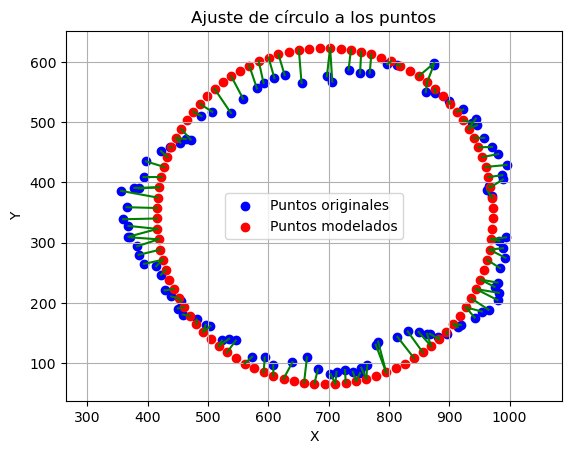

In [48]:

# Captura de video desde la cámara
cap = cv2.VideoCapture(0)

# Set the dimensions
frame_width = 1280
frame_height = 720
cap.set(cv2.CAP_PROP_FRAME_WIDTH, frame_width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, frame_height)

tracking_positions = []
tracking_started = False
start_time = None
initial_position = None

# Mostrar cuenta atrás antes de iniciar el seguimiento
for i in range(3, 0, -1):
    for j in range(10):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.flip(frame, 1)  # Invertir la imagen
        cv2.putText(frame, f"Comienza en {i}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        cv2.imshow('Seguimiento de Luz', frame)
        cv2.waitKey(100)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip(frame, 1)  # Invertir la imagen
    detected = detect_bright_object(frame)
    if detected:
        measured = np.array([[np.float32(detected[0])], [np.float32(detected[1])]])
        kalman.correct(measured)

        if not tracking_started:
            tracking_started = True
            start_time = time.time()
            initial_position = detected

    # Predicción del filtro de Kalman
    predicted = kalman.predict()
    predicted_x, predicted_y = int(predicted[0].item()), int(predicted[1].item())

    # Dibujar en la imagen
    if detected:
        cv2.circle(frame, detected, 10, (0, 255, 0), 2)
        if tracking_started:
            tracking_positions.append(detected)

    for i in range(1, len(tracking_positions)):
        cv2.line(frame, tracking_positions[i - 1], tracking_positions[i], (0, 0, 255), 2)

    cv2.circle(frame, (predicted_x, predicted_y), 10, (255, 0, 0), 2)

    # Mostrar tiempo
    elapsed_time = time.time() - start_time if tracking_started else 0
    cv2.putText(frame, f"Tiempo transcurrido: {elapsed_time:.2f} s", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

    # Mostrar la imagen
    cv2.imshow('Seguimiento de Luz', frame)

    # Verificar si han pasado al menos 3 segundos desde que comenzó el seguimiento
    if tracking_started and (time.time() - start_time) > 1:
        if (time.time() - start_time) > 6:
            print("Demasiado lento")
            break
        if detected and initial_position and euclidean_distance(detected, initial_position) < 40:
            if (time.time() - start_time) < 3:
                print("Demasiado rápido")
                break
            #Eliminar puntos duplicados o muy parecidos
            tracking_positions = [tracking_positions[i] for i in range(len(tracking_positions)) if i == 0 or euclidean_distance(tracking_positions[i], tracking_positions[i-1]) > 3]
            # for i in range(len(tracking_positions)):
                # tracking_positions[i] = (tracking_positions[i][0], abs(tracking_positions[i][1]-479))
            print("Posiciones registradas: ", tracking_positions)
            print("Número de posiciones registradas: ", len(tracking_positions))

            # Calcular la semejanza de círculo para las posiciones registradas
            circulo = ajustar_circulo(tracking_positions)
            if circulo[2] < 125:
                print("Círculo demasiado pequeño")
            else:
                puntos_circulo = generar_puntos_circulo(circulo[0], circulo[1], circulo[2], len(tracking_positions))
                semejanza, puntos_unidos = calcular_semejanza(tracking_positions, puntos_circulo, circulo[2])
                print("Semejanza del círculo:", semejanza)
                plot_circulo(tracking_positions, puntos_circulo, puntos_unidos)
            break

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
